In [1]:
def get_Label(number):
    labels = {0:'Cat', 1:'Dog'}
    return labels[number]


#plot predction function
def plot_predection(model_name):
    plt.figure(figsize=(20,15))
    plt.suptitle("Predection  Images", fontsize=20)
    images = [] 
    path ='test1/'
    count = 0  #val_images,val_labels
    for i,files in enumerate(os.listdir(path)) :
        img = plt.imread(path+files)
        img = cv2.resize(img,(128,128))
        plt.imshow(img,cmap=plt.cm.binary)
        img = np.expand_dims(img, axis=0)
        feature = model_name.predict(img)
        predection  = np.argmax(feature, axis=1)
        plt.subplot(5,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel("Predicted"+get_Label(int(predection)))
        count += 1
        if count == 34 :
            break    

In [4]:
#Читаем обучающую выборку

import os
import pandas as pd
all_categories = []
images = os.listdir('../dogs-vs-cats/train')
for file in images:
    if file.split('.')[0] == 'dog':
        all_categories.append(1)
    else:
        all_categories.append(0)
        
df =pd.DataFrame({
    'image': images,
    'category':all_categories
})

df.head(5)

,image,category
0,dog.8673.jpg,1
1,cat.11622.jpg,0
2,dog.5841.jpg,1
3,dog.7794.jpg,1
4,dog.6963.jpg,1


In [5]:
df["category"].value_counts()

1    12500
0    12500
Name: category, dtype: int64

In [19]:
#Читаем тестовую выборку
all_categories_test = []
test_images = os.listdir('../dogs-vs-cats/test1')
for file in test_images:
    if file.split('.')[0] == 'dog':
        all_categories_test.append(1)
    else:
        all_categories_test.append(0)
#creat data fram to save each image with its label 
df_test =pd.DataFrame({
    'image': test_images,
    'category':all_categories_test
})
df_test.head(5)

,image,category
0,11279.jpg,0
1,4930.jpg,0
2,11741.jpg,0
3,10837.jpg,0
4,4079.jpg,0


In [7]:
df_test["category"].value_counts()

0    12500
Name: category, dtype: int64

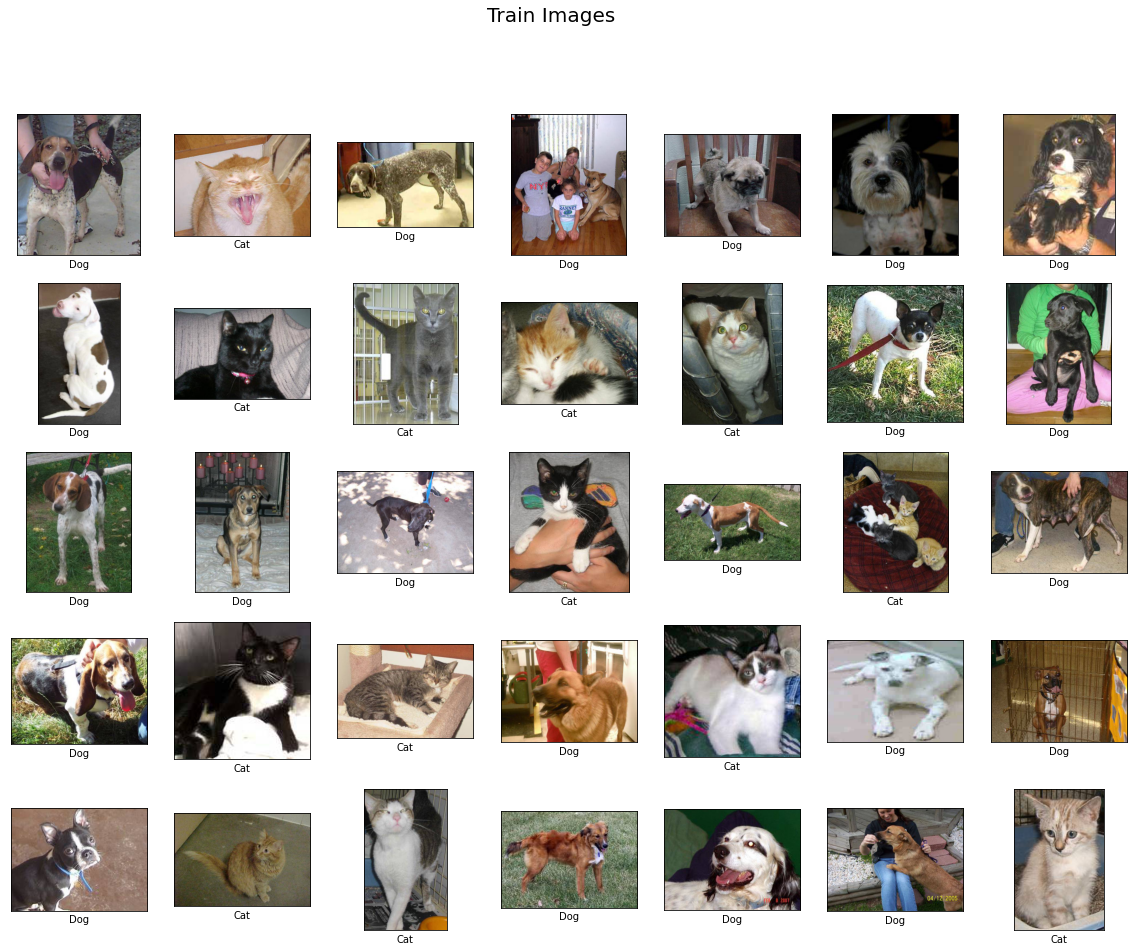

In [20]:
# Посмотрим на датасеты

import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.suptitle("Train Images", fontsize=20)
path ='../dogs-vs-cats/train/'
counter =0
for i,img in enumerate(os.listdir(path))  :
        plt.subplot(5,7,i+1)
        full_image= plt.imread(path+img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(get_Label(all_categories[i]))
        plt.imshow(full_image, cmap=plt.cm.binary) 
        if i == 34:
            break

In [10]:
# Выделим валидационную выборку

from sklearn.model_selection import train_test_split
x_train, x_val  = train_test_split(df ,random_state=42,shuffle=True,test_size=0.2)

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
print('Train Images shape is        : ',x_train.shape)
print('Validation  Images  shape is : ',x_val.shape)

Train Images shape is        :  (20000, 2)
Validation  Images  shape is :  (5000, 2)


In [12]:
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class CatDogDataset(Dataset):
    
    def __init__(self, images_list, mode="train", transform=None):
        self.images_list = images_list
        self.mode = mode
        self.transform = transform
        
    # dataset length
    def __len__(self):
        self.dataset_len = len(self.images_list)
        return self.dataset_len
    
    # load an image
    def __getitem__(self, idx):
        image_name = self.images_list[idx]
        if self.mode == "train" or self.mode == "val":
            image_path = "../dogs-vs-cats/train/"
        else:
            image_path = "../dogs-vs-cats/test1/"
        image = Image.open(image_path + image_name)
        
        preprocess = transforms.Compose([
#             transforms.Resize(256),
            transforms.RandomResizedCrop(224, scale=(0.8,1.0),ratio=(1.0,1.0)),
#             transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        transformed_image = preprocess(image)
        #input_batch = input_tensor.unsqueeze(0)

        image_category = image_name.split("/")[-1].split(".")[0]
        
        if self.mode == "train" or self.mode == "val":
            if image_category == "cat":
                label = 0 
            else:
                label = 1              
            return transformed_image, label
        else:
            return transformed_image

In [13]:
batch_size = 128
num_epochs = 10
learning_rate = 0.01

# create dataset objects
train_dataset = CatDogDataset(x_train['image'])
val_dataset = CatDogDataset(x_val['image'], mode="val")
test_dataset = CatDogDataset(df_test['image'], mode="val")

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


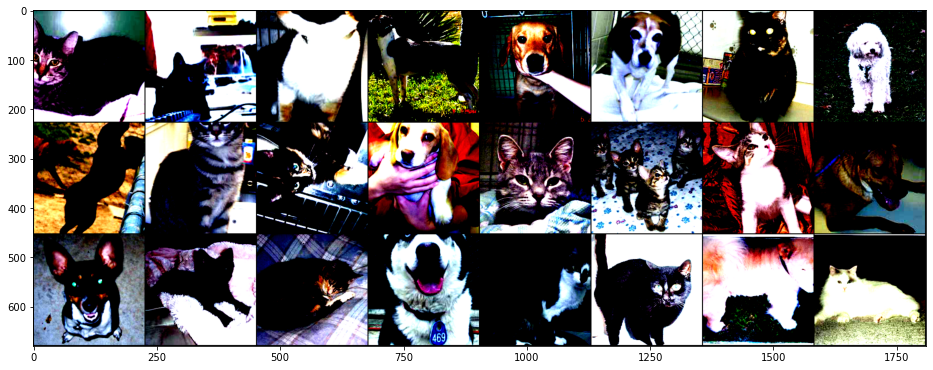

In [14]:
samples, labels = next(iter(val_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=0, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=0, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=0, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 24 * 24, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=2)
        )
    
    def forward(self, x):
        out = self.cnn_layers(x)
        out = out.view(-1, 64 * 24 * 24)
        out = self.linear_layers(out)
        return out
    
    def __len__(self):
        return 0
    

In [17]:
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = Model()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [18]:
#define criterion 
#define optimizer
#define model
from tqdm import tqdm

num_epochs = 10

train_losses = []
val_losses = []
accuracy_list = []

for epoch in range(num_epochs):  
    
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader):
        
        images = images.to(device)
        labels = labels.to(device)

        # print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(running_loss)


    # calculate training loss for the epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Смотрим качество на валидационном датасете
    model.eval()
    running_loss = 0.0
    num_correct = 0
    num_predictions = 0

    with torch.no_grad():  
        for images, labels in tqdm(val_dataloader):

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            num_correct += (predicted == labels).sum().item()
            num_predictions += labels.size(0)
            print(running_loss, predicted, )
    
    # calculate val loss for epoch
    val_losses.append(running_loss / len(val_dataloader))
    
    # calculate accuracy for epoch
    accuracy = num_correct / num_predictions * 100
    accuracy_list.append(accuracy)
    
    print("[Epoch: %d / %d],  [Train loss: %.4f],  [Test loss: %.4f],  [Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], accuracy))

  3%|▎         | 5/157 [00:56<28:24, 11.22s/it]


KeyboardInterrupt: 

In [ ]:
path2model = '../model.pth"
torch.save(model.state_dict(), path2model)